In [18]:
import numpy as np
import sys,os
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

In [19]:
work_space = os.getcwd()
# load the game resources
def load():
    # path of player with different states
    PLAYER_PATH = (
            work_space+'/assets/sprites/redbird-upflap.png',
            work_space+'/assets/sprites/redbird-midflap.png',
            work_space+'/assets/sprites/redbird-downflap.png'
    )

    # path of background
    BACKGROUND_PATH = work_space+'/assets/sprites/background-black.png'

    # path of pipe
    PIPE_PATH = work_space+'/assets/sprites/pipe-green.png'

    IMAGES, HITMASKS = {}, {}

    # numbers sprites for score display
    IMAGES['numbers'] = (
        pygame.image.load(work_space+'/assets/sprites/0.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/1.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/2.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/3.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/4.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/5.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/6.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/7.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/8.png').convert_alpha(),
        pygame.image.load(work_space+'/assets/sprites/9.png').convert_alpha()
    )

    # base (ground) sprite
    IMAGES['base'] = pygame.image.load(work_space+'/assets/sprites/base.png').convert_alpha()

    # select random background sprites
    IMAGES['background'] = pygame.image.load(BACKGROUND_PATH).convert()

    # select random player sprites
    IMAGES['player'] = (
        pygame.image.load(PLAYER_PATH[0]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[1]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[2]).convert_alpha(),
    )

    # select random pipe sprites
    IMAGES['pipe'] = (
        pygame.transform.rotate(
            pygame.image.load(PIPE_PATH).convert_alpha(), 180),
        pygame.image.load(PIPE_PATH).convert_alpha(),
    )

    # hismask for pipes
    HITMASKS['pipe'] = (
        getHitmask(IMAGES['pipe'][0]),
        getHitmask(IMAGES['pipe'][1]),
    )

    # hitmask for player
    HITMASKS['player'] = (
        getHitmask(IMAGES['player'][0]),
        getHitmask(IMAGES['player'][1]),
        getHitmask(IMAGES['player'][2]),
    )

    return IMAGES, HITMASKS

In [20]:
def getHitmask(image):
    """returns a hitmask using an image's alpha."""
    mask = []
    for x in range(image.get_width()):
        mask.append([])
        for y in range(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3]))
    return mask

In [21]:
# disenabling the game display
os.environ["SDL_VIDEODRIVER"] = "dummy"
FPS = 30
SCREENWIDTH  = 288
SCREENHEIGHT = 512
# initialize game module
pygame.init()
FPSCLOCK = pygame.time.Clock()
# set the screen mode
# NOTE : You must pass the depth argument which represent the number of bits to use fo color in disenabling display mode.
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT),0,32)
pygame.display.set_caption('Flappy Bird')
IMAGES, HITMASKS = load()
PIPEGAPSIZE = 100 # gap between upper and lower part of pipe
BASEY = SCREENHEIGHT * 0.79

PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()
BACKGROUND_WIDTH = IMAGES['background'].get_width()
PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])

In [22]:
class GameState:
    def __init__(self):
        self.score = self.playerIndex = self.loopIter = 0
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
        self.basex = 0
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH

        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        # player velocity, max velocity, downward accleration, accleration on flap
        self.pipeVelX = -4
        self.playerVelY    =  0    # player's velocity along Y, default same as playerFlapped
        self.playerMaxVelY =  10   # max vel along Y, max descend speed
        self.playerMinVelY =  -8   # min vel along Y, max ascend speed
        self.playerAccY    =   1   # players downward accleration
        self.playerFlapAcc =  -9   # players speed on flapping
        self.playerFlapped = False # True when player flaps

    def frame_step(self, input_actions):
        pygame.event.pump()

        reward = 0.1
        terminal = False

        if sum(input_actions) != 1:
            raise ValueError('Multiple input actions!')

        # input_actions[0] == 1: do nothing
        # input_actions[1] == 1: flap the bird
        if input_actions[1] == 1:
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True
                #SOUNDS['wing'].play()

        # check for score
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        for pipe in self.upperPipes:
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                self.score += 1
                #SOUNDS['point'].play()
                reward = 1

        # playerIndex basex change
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)

        # player's movement
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0

        # move pipes to left
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])

        # remove first pipe if its out of the screen
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)

        # check if crash here
        isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.upperPipes, self.lowerPipes)
        if isCrash:
            #SOUNDS['hit'].play()
            #SOUNDS['die'].play()
            terminal = True
            self.__init__()
            reward = -1

        # draw sprites
        SCREEN.blit(IMAGES['background'], (0,0))

        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        # print score so player overlaps the score
        # showScore(self.score)
        SCREEN.blit(IMAGES['player'][self.playerIndex],
                    (self.playerx, self.playery))

        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        #print ("FPS" , FPSCLOCK.get_fps())
        FPSCLOCK.tick(FPS)
        #print self.upperPipes[0]['y'] + PIPE_HEIGHT - int(BASEY * 0.2)
        return image_data, reward, terminal

def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10

    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False


In [23]:
def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False

In [45]:
#!/usr/bin/env python
from __future__ import print_function

import argparse
import skimage as skimage
from skimage import transform, color, exposure, io
from skimage.transform import rotate
from skimage.viewer import ImageViewer
import random
import numpy as np
from collections import deque
import json
from zoo.pipeline.api.net import Net
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import Dense, Dropout, Activation,Flatten
from zoo.pipeline.api.keras.layers.convolutional import Convolution2D
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plot
import matplotlib.image as image
from zoo.pipeline.api.net import Net
from os import listdir
from os.path import isfile, join, getmtime
import imageio

In [46]:
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 2 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 32. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 80, 80
#Convert image into Black and white
img_channels = 4 #We stack 4 frames
BASE_PATH = os.getcwd()
SAVE_GIF = 200 # timesteps to save the gif
step_record = list()

In [47]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Convolution2D(32, 8, 8, subsample=(4, 4), border_mode='same',
                            input_shape=(img_rows, img_cols, img_channels)))  # 80*80*4
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2))
    print("We finish building the model")
    return model



In [48]:
def playGame(model , is_train = True):

    living_step = 0
    # open up a game state to communicate with emulator
    game_state = GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t, (80, 80))
    x_t = skimage.exposure.rescale_intensity(x_t, out_range=(0, 255))

    x_t = x_t / 255.0

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    # print (s_t.shape)

    # In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  # 1*80*80*4
    
    if is_train:   
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON
    else:
        OBSERVE = 999999999  # We keep observe, never train
        epsilon = FINAL_EPSILON
    # how many step to execute
    execute_step = 0
    if is_train:
        execute_step = 3000000
    else:
        execute_step = 1000
        
        
    gifSaveCount = 0
    saveImage = False
    t = 0
    while (t<execute_step): 
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        # choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)# input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1
        # We reduced the epsilon gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        # run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1, (80, 80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))
        
        if t % SAVE_GIF == 0:
            saveImage = True
            if os.path.exists('./img'):
                for filename in os.listdir('./img'):
                    file_path = os.path.join(os.getcwd(),filename)
                    if os.path.isfile(file_path):
                        os.remove(file_path)
            else:
                os.mkdir('./img')



        if saveImage:
            rotate_x_t1_image = transform.rotate(x_t1_colored,270,resize=True)
            io.imsave('img/image'+str(gifSaveCount)+'.png',rotate_x_t1_image)
            gifSaveCount+=1
            if gifSaveCount > 100:
                saveToGif()
                gifSaveCount = 0
                saveImage = False
               
                    
        x_t1 = x_t1 / 255.0

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1)  # 1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        # only train if done observing
        if t > OBSERVE:
            # sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            model,loss = training(minibatch)

        s_t = s_t1
        t = t + 1
        if terminal:
            step_record.append(living_step)
            living_step = 0
        else:
            living_step += 1
        # save progress every 10000 iterations
        if t % 10000 == 0 and is_train:
            print("Now we save model")
            model.saveModel("/model/model"+str(t)+".bigdl","/model/model"+str(t)+".bin",True)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"
        print ("Living steps : ",living_step)
        print("TIMESTEP", t, "/ STATE", state, \
              "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,
              "/ Loss ", loss)

    print("Episode finished!")
    print("************************")
                

In [55]:
# loas a pretrained bigdl model# loas a  
def loadPretrainedBigdlModel(model_path, weight_path):
    print("Now we load weight")
    if model_path == None or not os.path.exists(model_path):
        print ("Not a valid model_path, training from scratch")
        raise Exception("not a valid model_path")
    else:
        if weight_path == None or not os.path.exists(weight_path):
            model =Sequential()
            print ("not a valid weight_path, using initialized weight")
            model=Net.load(model_path=model_path)
        else:
            # load_mode
            model=Net.load(model_path=model_path,weight_path=weight_path)
            print("Weights load successfully")
        playGame(model,False)      

In [56]:
# training model from scratch# trainin 
def trainModel():
    model = buildMode()
    model.compile(loss='mse', optimizer='adam')
    playGame(model)

In [57]:
def saveToGif():
    mypath = os.getcwd() + '/img'
    filenames = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    path_dict = {}
    for i in range(len(filenames)):
        path_dict[filenames[i]] = getmtime(join(mypath, filenames[i]))
    sorted_filenames = sorted(path_dict.items(), key=lambda x: x[1], reverse=False)
    with imageio.get_writer('./movie.gif', mode='I', fps=10) as writer:
        for filename in sorted_filenames:
            image = imageio.imread('./img/' + filename[0])
            writer.append_data(image)

In [58]:
def training(minibatch):
    # Now we do the experience replay
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = np.zeros((BATCH,ACTIONS))
    Q_sa = model.predict(state_t1)
    result_qsa=Q_sa.map(lambda elem:max(elem)).collect()
    for i in range(BATCH):
        targets[i][action_t[i]] = reward_t[i] + GAMMA *result_qsa[i] * np.invert(terminal[i])
    model.fit(state_t,targets)
    loss = getLoss(model,state_t,targets)
    return model,loss

In [59]:
def getLoss(model,state,targets):
    # get the predict result in RDD type
    predict_state = model.predict(state)
    item_list = predict_state.collect()
    loss = 0
    i = 0
    for predict_actions in item_list:
        loss += 0.5 * np.square(np.abs(targets[i][0]-predict_actions[0])+np.abs(targets[i][1]-predict_actions[1]))
        i+=1
    predict_state = None
    print ("**************************************LOSS***********************************: %s"%(loss/BATCH))
    return loss/BATCH

In [63]:
# now we load a pretrained bigdl model
model_path = "./model/model31500.bigdl"
weight_path = "./model/model31500.bin"
loadPretrainedBigdlModel(model_path,weight_path)

Now we load weight
Weights load successfully
Living steps :  1
TIMESTEP 1 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  2
TIMESTEP 2 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  3
TIMESTEP 3 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  4
TIMESTEP 4 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  5
TIMESTEP 5 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  6
TIMESTEP 6 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  7
TIMESTEP 7 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  8
TIMESTEP 8 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  9
TIMESTEP 9 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  10
TIMESTEP 10 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / L

TIMESTEP 88 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  40
TIMESTEP 89 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  41
TIMESTEP 90 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  42
TIMESTEP 91 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  43
TIMESTEP 92 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  44
TIMESTEP 93 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  45
TIMESTEP 94 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  46
TIMESTEP 95 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  47
TIMESTEP 96 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  48
TIMESTEP 97 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  49
TIMESTEP 98 / STATE 

Living steps :  29
TIMESTEP 178 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  30
TIMESTEP 179 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  31
TIMESTEP 180 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  32
TIMESTEP 181 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  33
TIMESTEP 182 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  34
TIMESTEP 183 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  35
TIMESTEP 184 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  36
TIMESTEP 185 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  37
TIMESTEP 186 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  38
TIMESTEP 187 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  12
TIMESTEP 261 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  13
TIMESTEP 262 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  14
TIMESTEP 263 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  15
TIMESTEP 264 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  16
TIMESTEP 265 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  17
TIMESTEP 266 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  18
TIMESTEP 267 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  19
TIMESTEP 268 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  20
TIMESTEP 269 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  21
TIMESTEP 270 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  49
TIMESTEP 348 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  0
TIMESTEP 349 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -1 / Loss  0
Living steps :  1
TIMESTEP 350 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  2
TIMESTEP 351 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  3
TIMESTEP 352 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  4
TIMESTEP 353 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  5
TIMESTEP 354 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  6
TIMESTEP 355 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  7
TIMESTEP 356 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  8
TIMESTEP 357 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  9
TI

Living steps :  34
TIMESTEP 433 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  35
TIMESTEP 434 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  36
TIMESTEP 435 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  37
TIMESTEP 436 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  38
TIMESTEP 437 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  39
TIMESTEP 438 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  40
TIMESTEP 439 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  41
TIMESTEP 440 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  42
TIMESTEP 441 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  43
TIMESTEP 442 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  23
TIMESTEP 522 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  24
TIMESTEP 523 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  25
TIMESTEP 524 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  26
TIMESTEP 525 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  27
TIMESTEP 526 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  28
TIMESTEP 527 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  29
TIMESTEP 528 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  30
TIMESTEP 529 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  31
TIMESTEP 530 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  32
TIMESTEP 531 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  9
TIMESTEP 608 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  10
TIMESTEP 609 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  11
TIMESTEP 610 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  12
TIMESTEP 611 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  13
TIMESTEP 612 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  14
TIMESTEP 613 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  15
TIMESTEP 614 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  16
TIMESTEP 615 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  17
TIMESTEP 616 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  18
TIMESTEP 617 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living step

Living steps :  44
TIMESTEP 693 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  45
TIMESTEP 694 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  46
TIMESTEP 695 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  47
TIMESTEP 696 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  48
TIMESTEP 697 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  49
TIMESTEP 698 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  0
TIMESTEP 699 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -1 / Loss  0
Living steps :  1
TIMESTEP 700 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  2
TIMESTEP 701 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  3
TIMESTEP 702 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps : 

Living steps :  28
TIMESTEP 777 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  29
TIMESTEP 778 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  30
TIMESTEP 779 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  31
TIMESTEP 780 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  32
TIMESTEP 781 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  33
TIMESTEP 782 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  34
TIMESTEP 783 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  35
TIMESTEP 784 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  36
TIMESTEP 785 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  37
TIMESTEP 786 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living ste

Living steps :  13
TIMESTEP 862 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  14
TIMESTEP 863 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  15
TIMESTEP 864 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  16
TIMESTEP 865 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  17
TIMESTEP 866 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  18
TIMESTEP 867 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  19
TIMESTEP 868 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  20
TIMESTEP 869 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  21
TIMESTEP 870 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  22
TIMESTEP 871 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  49
TIMESTEP 948 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  0
TIMESTEP 949 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD -1 / Loss  0
Living steps :  1
TIMESTEP 950 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  2
TIMESTEP 951 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  3
TIMESTEP 952 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  4
TIMESTEP 953 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  5
TIMESTEP 954 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  6
TIMESTEP 955 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  7
TIMESTEP 956 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  8
TIMESTEP 957 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  9
TI

In [64]:
print("now we print the generated gif image")
from IPython.display import Image
Image(url='./movie.gif')

now we print the generated gif image


now we print the living steps


Text(0,0.5,'living steps')

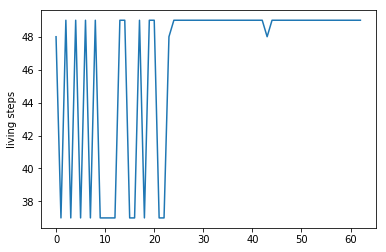

In [65]:
print("now we print the living steps")
y_value = [step for step in step_record]
plot.plot(y_value)
plot.ylabel("living steps")